### Two connected nodes

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding/")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate, simulate_delayed

In [3]:
jax.config.update("jax_platform_name", "cpu")

In [4]:
jax.device_count()

1

In [5]:
def circular_hist(
    ax, x, bins=16, density=True, offset=0, gaps=True, fill=False, alpha=0.3, color="b"
):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x + np.pi) % (2 * np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins + 1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area / np.pi) ** 0.5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(
        bins[:-1],
        radius,
        zorder=1,
        align="edge",
        width=widths,
        edgecolor="k",
        fill=fill,
        linewidth=1,
        alpha=alpha,
        color=color,
    )

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

#### Simulation parameters

In [6]:
Nareas = 2
ntrials = 500
fsamp = 1 / 1e-4

time = np.arange(-4, 4, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 20

C = np.array([[0, 1], [0, 0]]).T

f = 40

In [7]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 1)] = 1
Amplitudes = np.linspace(0, 30, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [8]:
simulate_loop = jax.vmap(
    simulate, in_axes=(None, 0, None, None, None, None, None, 0, 0, None, None, None)
)

In [9]:
out = simulate_loop(
    C,
    CS[:, 0],
    np.array([40, 40]),
    np.array([-5, -5]),
    fsamp,
    1e-4,
    Npoints,
    None,
    seeds,
    "cpu",
    decim,
    "both",
)

In [ ]:
stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y"], time[::decim]),
).sel(times=slice(-2, 4))

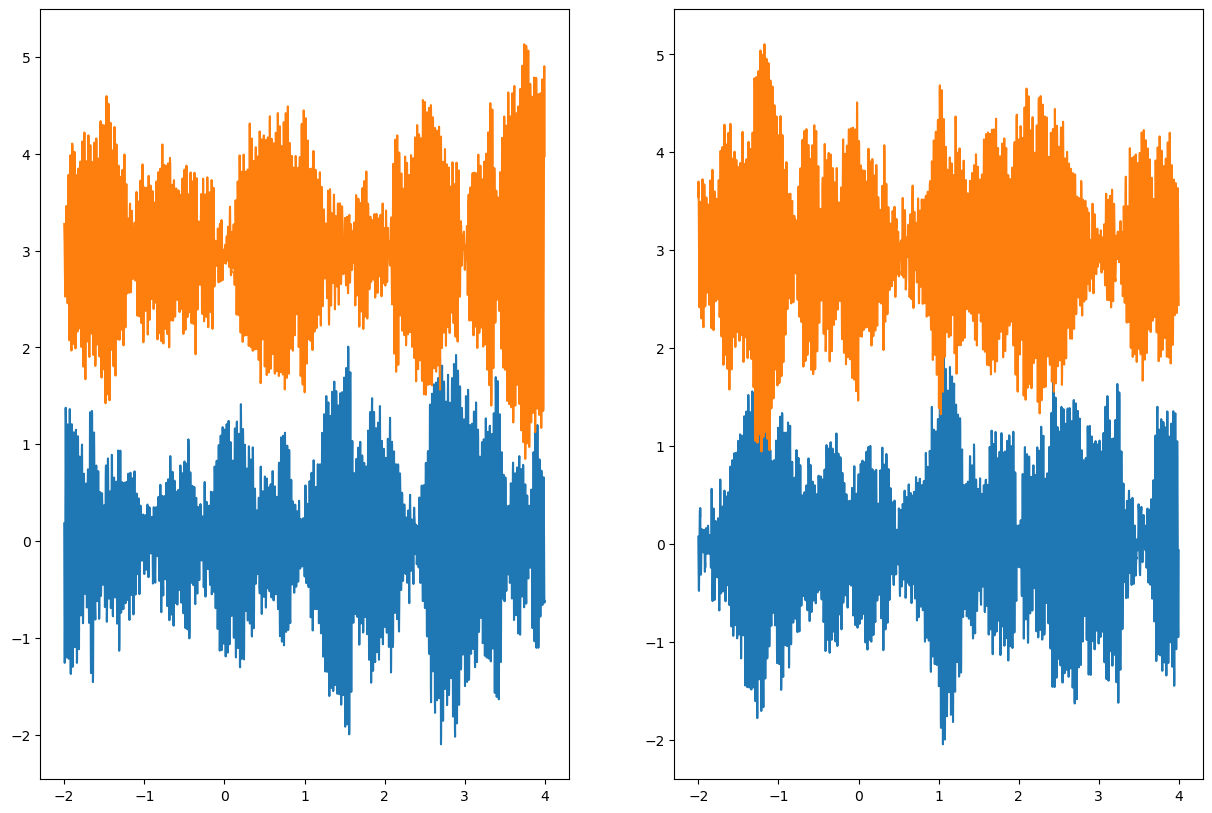

In [251]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [252]:
data_ = data.sel(times=slice(0, 1))

In [253]:
theta1 = np.angle(data_[:, 0])
theta2 = np.angle(data_[:, 1])

In [254]:
delta = (theta2 - theta1 + np.pi) % (2 * np.pi) - np.pi

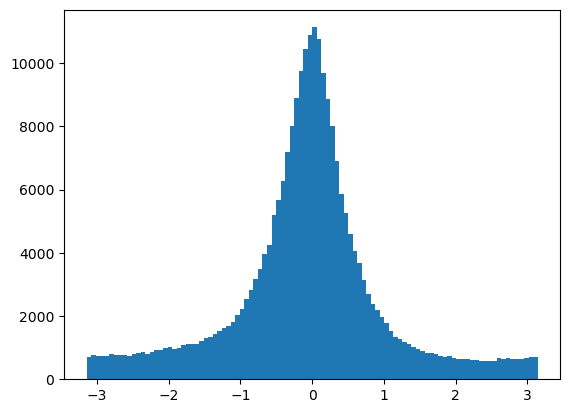

In [255]:
plt.hist(delta.flatten(), 100);

/tmp/ipykernel_2903/3237201603.py:2: RuntimeWarning: invalid value encountered in arcsin
  plt.plot(Amplitudes[1:], np.arcsin(1 / (2 * Amplitudes[1:])), "--")


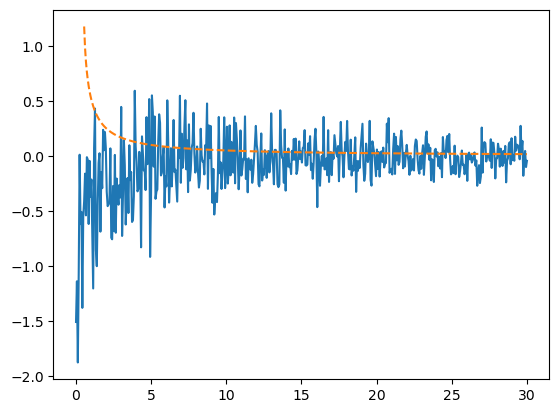

In [256]:
plt.plot(Amplitudes, delta.mean(1))
plt.plot(Amplitudes[1:], np.arcsin(1 / (2 * Amplitudes[1:])), "--")

In [257]:
import scipy
from frites.core import (
    copnorm_nd,
    gccmi_nd_ccc,
    gcmi_1d_cc,
    gcmi_model_nd_cd,
    gcmi_nd_cc,
)

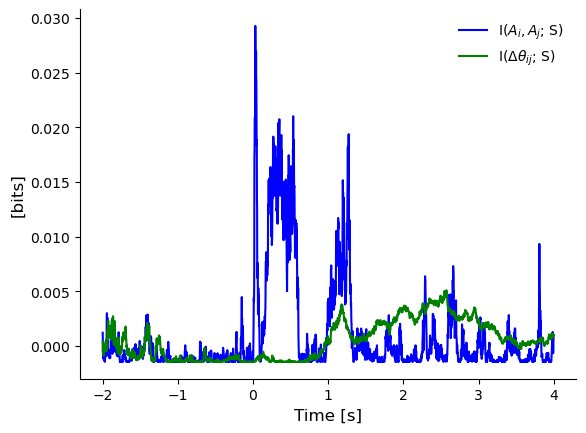

In [258]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])
z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

ax = plt.subplot(111)
plt.plot(data.times, I_S_R1, "b")
plt.plot(data.times, I_S_R2, "g")

plt.legend(
    [
        r"I($A_{i}, A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.savefig("figures/sample_encoding_evoked_potential.png", bbox_inches="tight")

In [259]:
### Decompose in time-frequency domain
data.attrs["fsample"] = fsamp / decim
freqs = np.linspace(5, 80, 30)

S = tfr_array_multitaper(
    data.real,
    data.fsample,
    freqs,
    n_cycles=5,
    time_bandwidth=2,
    output="complex",
    n_jobs=1,
    decim=2,
    zero_mean=False,
).mean(2)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values[::2]},
)

In [260]:
z = S[:, 0] * np.conj(S[:, 1])

A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

In [261]:
labels = np.tile(
    np.expand_dims(Amplitudes, (1, 2)), (S.sizes["freqs"], S.sizes["times"])
)

In [262]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

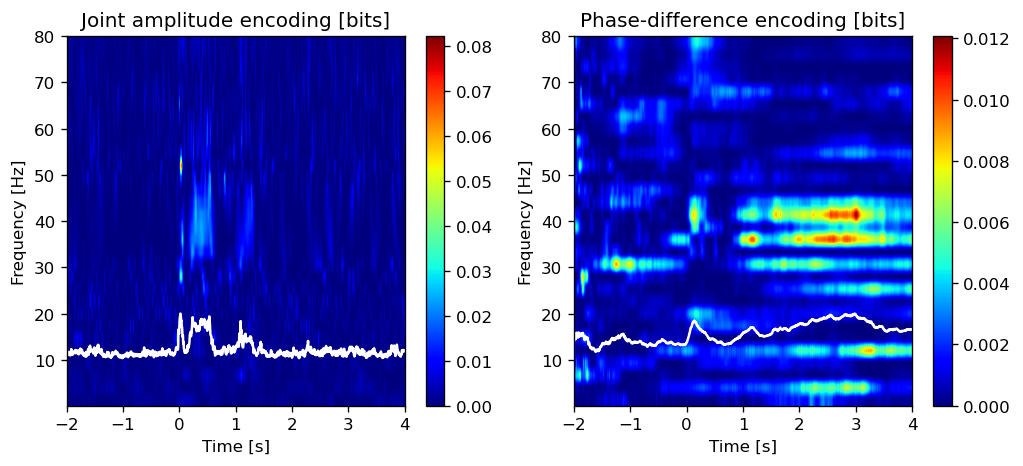

In [263]:
plt.figure(figsize=(10, 4), dpi=120)
plt.subplot(121)
MI_A = mi_fcn_time_frequency(A[None], labels[None], False, True)
plt.imshow(
    MI_A,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 0.1, 80],
    cmap="jet",
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Joint amplitude encoding [bits]")
plt.plot(S.times, MI_A.sum(0) / MI_A.sum(0).max() * 10 + 10, c="w")
plt.colorbar()

plt.subplot(122)
MI_PHI = mi_fcn_time_frequency(dphi[None], labels[None], False, True)
plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 0.1, 80],
    cmap="jet",
)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Phase-difference encoding [bits]")
plt.plot(S.times, MI_PHI.sum(0) / MI_PHI.sum(0).max() * 10 + 10, c="w")

plt.colorbar()

plt.savefig("figures/sample_tf_encoding_evoked_potential.png", bbox_inches="tight")

#### Sweep parameter space

In [13]:
# For the node receiving the input
f = 60
a = -5

a_list = np.linspace(-10, 2, 15)
f_list = np.linspace(60, 10, 15)

PAI = np.zeros((len(a_list), len(f_list)))

labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])

In [14]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])

ppe = np.zeros((3, 30, len(a_list)))

for pos_1, I in enumerate([0.1, 0.5, 1.0]):
    for pos_2, rep in enumerate(range(30)):
        data = xr.load_dataarray(
            f"/home/INT/lima.v/Results/phase_encoding/2nodes/data_sweep_a_f_{f}_I_{I}_rep_{rep}.nc",
            auto_complex=True,
        )

        pos = 1
        PAI = []

        for i, a_ in enumerate(a_list):
            z = data[i][:, 0] * np.conj(data[i][:, 1])
            A = np.abs(z).values
            dphi = np.unwrap(np.angle(z))

            I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
            I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

            ppe[pos_1, pos_2, i] = np.trapz(
                I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0]
            )

In [15]:
from frites.stats import confidence_interval

ppe_ci = confidence_interval(ppe, axis=1).squeeze()

    Estimating CI (cis=[95], axis=1, n_boots=200, skipna=True, random_state=None)


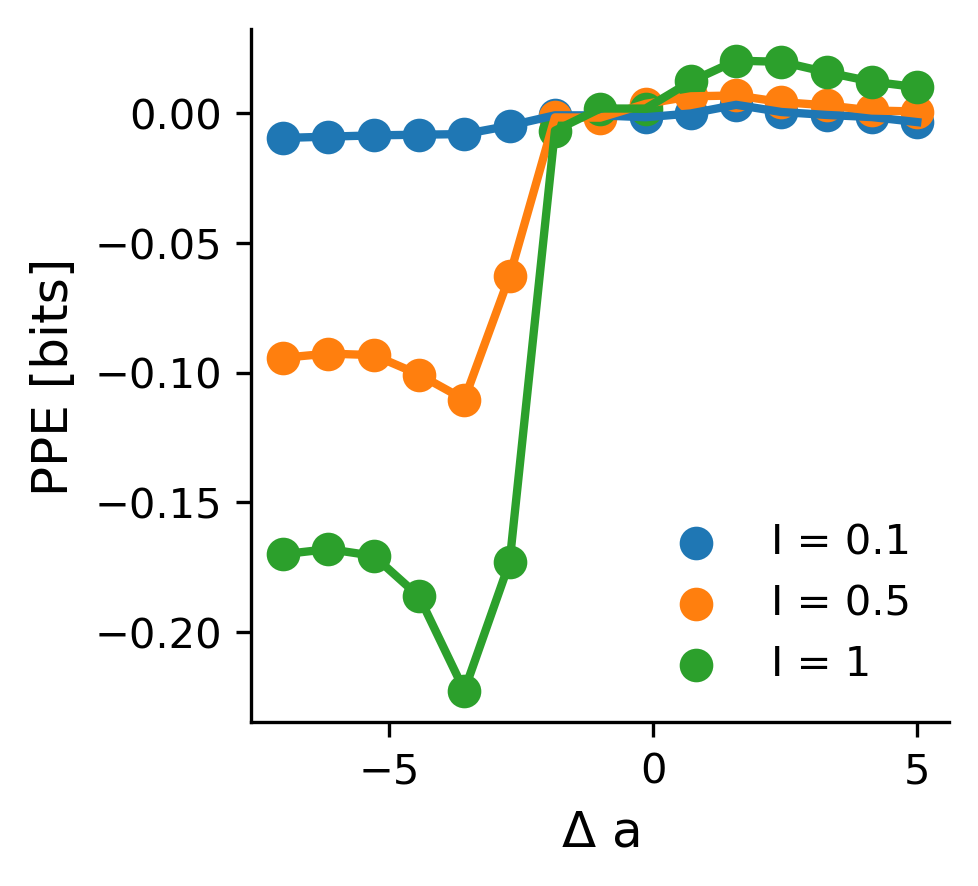

In [16]:
I = [0.1, 0.5, 1]
plt.figure(figsize=(3, 3), dpi=300)
ax = plt.subplot(111)
for i in range(3):
    x = np.median(ppe_ci, axis=0)[i]
    plt.plot(a - a_list, x, lw=2)
    plt.scatter(a - a_list, x, label=f"I = {I[i]}", s=50)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.legend(frameon=False)
plt.ylabel("PPE [bits]", fontsize=12)
plt.xlabel(r"$\Delta$ a", fontsize=12)
plt.savefig("figures/PPE_2nodes.png", bbox_inches="tight")

0.2978760624558889
0.7762768056774809


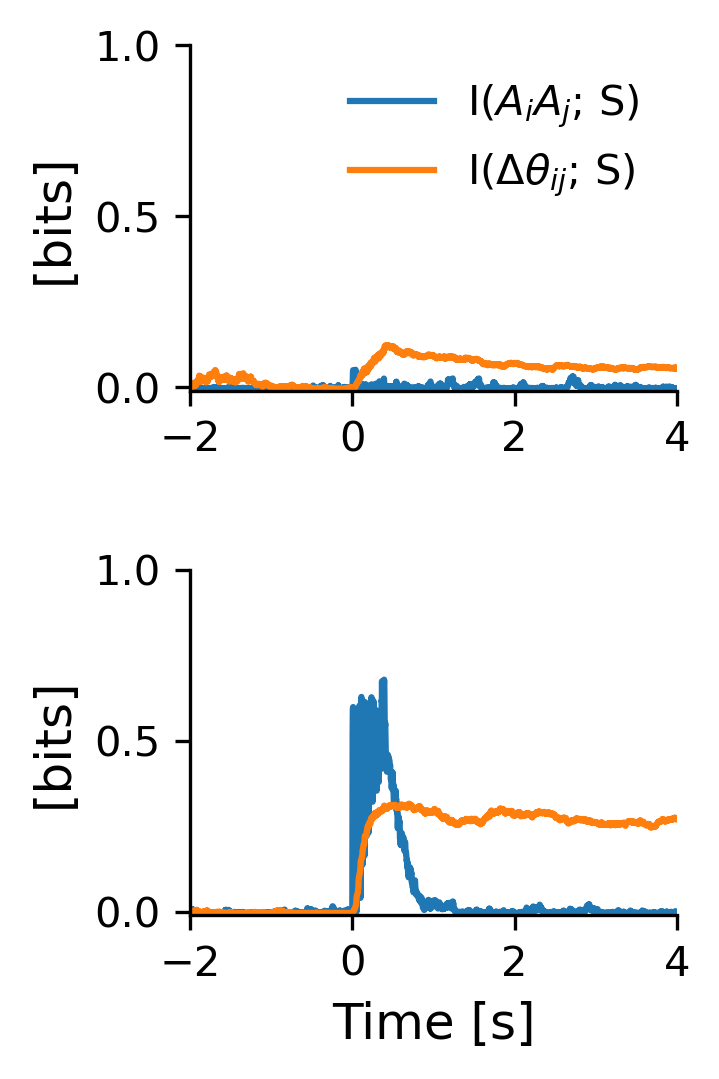

In [17]:
pos = 1
plt.figure(figsize=(2.5, 5), dpi=300)
color = ["#1f77b4", "#ff7f0e", "#2ca02c"]
f = 40
for I_ in [0.1, 1]:

    ax = plt.subplot(3, 1, pos)

    Iext = np.zeros((Nareas, Npoints))
    Iext[0, (time >= 0) & (time <= 0.4)] = I_
    Amplitudes = np.linspace(0, 0.1, ntrials)
    CS = Amplitudes[..., None, None] * Iext
    seeds = np.random.randint(0, 10000, ntrials)

    out = simulate_loop(
        C,
        1,
        np.array([f, f]),
        np.array([a, a]),
        fsamp,
        beta,
        Npoints,
        CS,
        seeds,
        "cpu",
        decim,
        "both",
    )

    stim = np.arange(ntrials)
    data = xr.DataArray(
        np.stack(out),
        dims=("trials", "roi", "times"),
        coords=(stim, ["x", "y"], time[::decim]),
    ).sel(times=slice(-2, 4))

    z = data[:, 0] * np.conj(data[:, 1])
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))

    I_S_R1 = gcmi_nd_cc(A, labels, traxis=0)
    I_S_R2 = gcmi_nd_cc(dphi, labels, traxis=0)

    plt.plot(data.times, I_S_R1)
    plt.plot(data.times, I_S_R2)
    if pos == 1:
        plt.legend([r"I($A_iA_j$; S)", r"I($\Delta\theta_{ij}$; S)"], frameon=False)
    if pos == 2:
        plt.xlabel("Time [s]", fontsize=12)
    plt.ylabel("[bits]", fontsize=12)
    plt.xlim(-2, 4)
    plt.ylim(-0.01, 1)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]

    print(np.trapz(I_S_R2 - I_S_R1, dx=np.diff(data.times.values)[0]))

    pos = pos + 1

plt.tight_layout()

plt.savefig("figures/amplitude_phase_ex2.png", bbox_inches="tight")

#### Example

In [18]:
s = 8 / (2 * np.pi * f)
time_start = 0
time_end = 0.8
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))

Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= time_start) & (time <= time_end)] = gaussian
Amplitudes = np.linspace(0, 0.1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [19]:
gaussian.max()

1.0

In [104]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])
decim = 10
f, a = 40, -5
beta = 1e-4

"""
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.05)] = 0.5
Amplitudes = np.linspace(0, 0.1, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)
"""

s = 8 / (2 * np.pi * f)
time_start = 0
time_end = 0.8
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))

Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= time_start) & (time <= time_end)] = gaussian
Amplitudes = np.linspace(0, 0.5, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)


out = simulate_loop(
    C,
    1,
    np.array([f, f]),
    np.array([a, a]),
    fsamp,
    beta,
    Npoints,
    CS,
    seeds,
    "cpu",
    decim,
    "both",
)

stim = np.arange(ntrials)
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(stim, ["x", "y"], time[::decim]),
).sel(times=slice(-2, 4))

z = data[:, 0] * np.conj(data[:, 1])
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

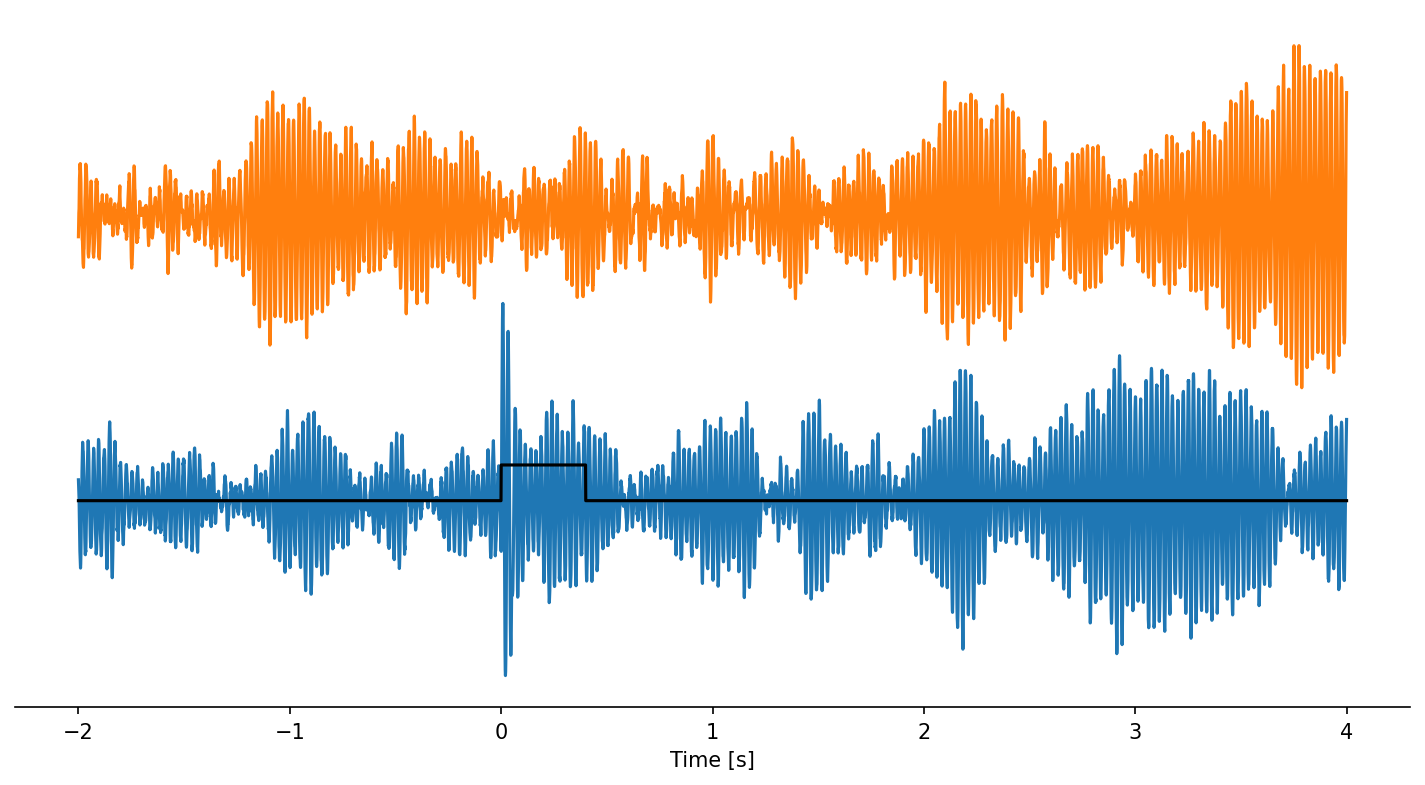

In [105]:
plt.figure(figsize=(12, 6), dpi=150)
ax = plt.subplot(111)

z_data = (data - data.mean("times")) / data.std("times")

for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 4))

boxcar = np.zeros(data.sizes["times"])
boxcar[(data.times.values >= 0) * (data.times.values <= 0.4)] = 0.5
plt.plot(z_data[-1].times, boxcar, c="k")

[ax.spines[key].set_visible(False) for key in ["top", "right", "left"]]
plt.yticks([])


plt.xlabel("Time [s]")

plt.savefig("figures/sample_time_series.png", bbox_inches="tight")

In [106]:
labels = np.tile(np.expand_dims(Amplitudes, 1), data.sizes["times"])

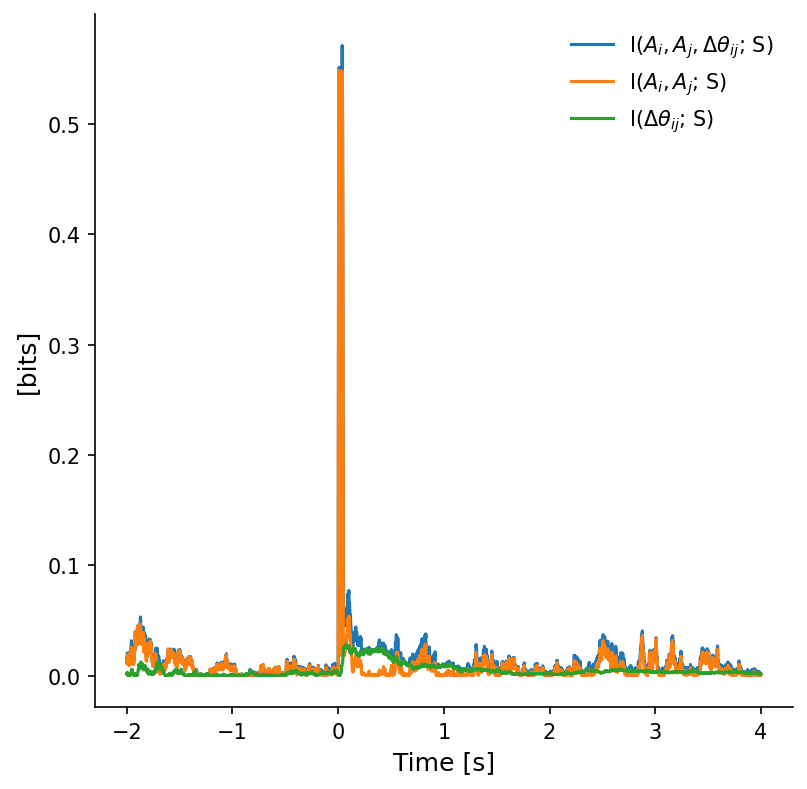

In [107]:
plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(111)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))


mv = jnp.stack((A, dphi), axis=0)


plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(A[None], labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(dphi[None], labels[None], False, True))

plt.legend(
    [
        r"I($A_{i}, A_{j}, \Delta\theta_{ij}$; S)",
        r"I($A_{i}, A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]


plt.savefig("figures/sample_MIs.png", bbox_inches="tight")

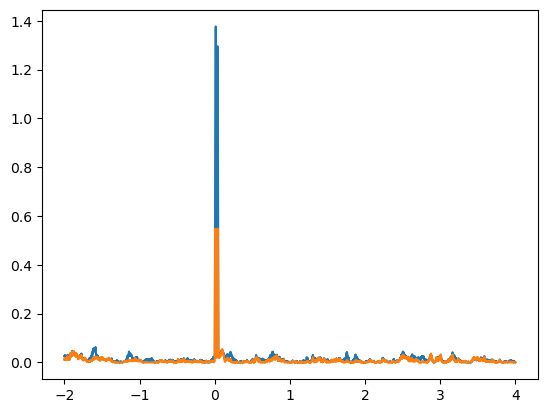

In [108]:
mv = jnp.stack(
    (np.abs(data[:, [0]]).values, np.abs(data[:, [1]]).values), axis=0
).squeeze()


plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(A[None], labels[None], False, True))

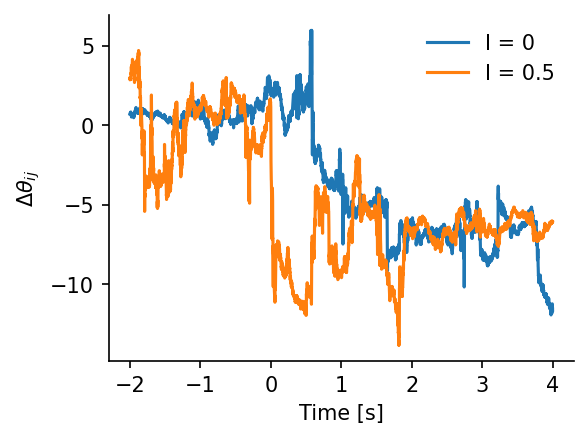

In [109]:
plt.figure(figsize=(4, 3), dpi=150)
ax = plt.subplot(111)

plt.plot(data.times, np.unwrap(np.angle(data[0][0] * np.conj(data[0][1]))))
plt.plot(data.times, np.unwrap(np.angle(data[-1][0] * np.conj(data[-1][1]))))
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.xlabel("Time [s]")
plt.ylabel(r"$\Delta\theta_{ij}$")


plt.legend(["I = 0", "I = 0.5"], frameon=False)

plt.savefig("figures/sample_delta_theta.png", bbox_inches="tight")

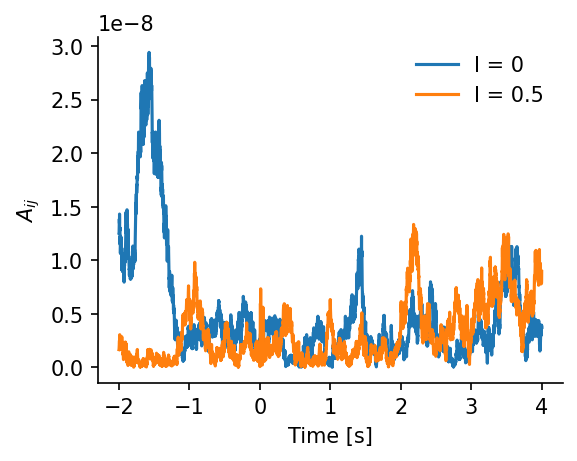

In [110]:
plt.figure(figsize=(4, 3), dpi=150)
ax = plt.subplot(111)


plt.plot(data.times, np.abs(data[0][0] * np.conj(data[0][1])))
plt.plot(data.times, np.abs(data[-1][0] * np.conj(data[-1][1])))

plt.xlabel("Time [s]")
plt.ylabel(r"$A_{ij}$")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.legend(["I = 0", "I = 0.5"], frameon=False)

plt.savefig("figures/sample_amp_comod.png", bbox_inches="tight")

In [112]:
### Decompose in time-frequency domain
data.attrs["fsample"] = fsamp / decim
freqs = np.linspace(0.1, 80, 50)

S = tfr_array_morlet(
    data.real,
    data.fsample,
    freqs,
    freqs,
    output="complex",
    n_jobs=1,
    decim=2,
    zero_mean=False,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values[::2]},
)

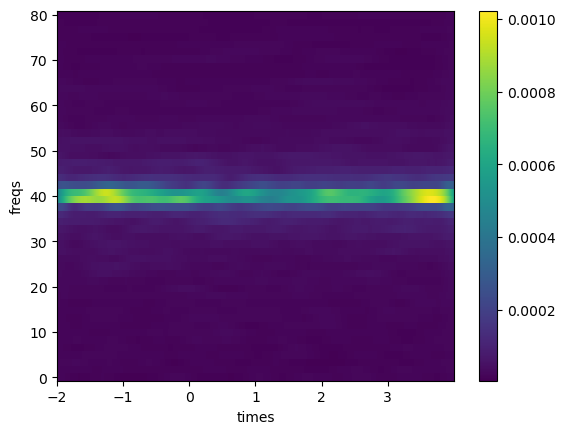

In [113]:
np.abs(S).mean(axis=0)[1].plot()

In [114]:
z = S[:, 0] * np.conj(S[:, 1])

A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

In [115]:
labels = np.tile(
    np.expand_dims(Amplitudes, (1, 2)), (S.sizes["freqs"], S.sizes["times"])
)

In [116]:
A.shape

(200, 50, 3000)

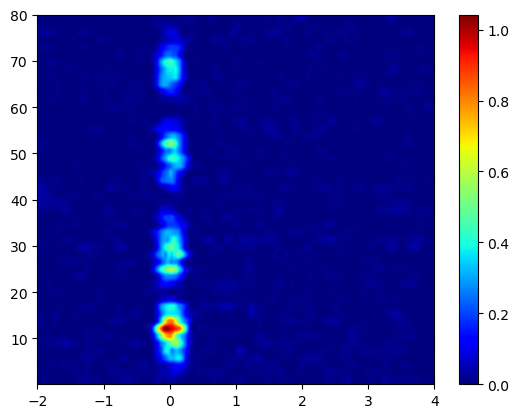

In [117]:
plt.imshow(
    mi_fcn_time_frequency(A[None], labels[None], False, True),
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 0.1, 80],
    cmap="jet",
)
plt.colorbar()

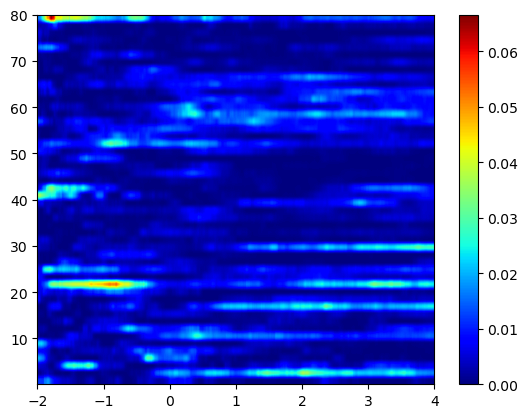

In [118]:
plt.imshow(
    mi_fcn_time_frequency(dphi[None], labels[None], False, True),
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 0.1, 80],
    cmap="jet",
)
plt.colorbar()

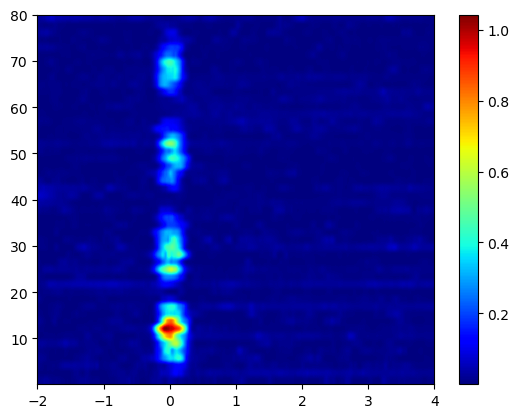

In [119]:
mv = jnp.stack((A, dphi), axis=0)

plt.imshow(
    mi_fcn_time_frequency(mv, labels[None], False, True),
    aspect="auto",
    origin="lower",
    extent=[-2, 4, 0.1, 80],
    cmap="jet",
)
plt.colorbar()

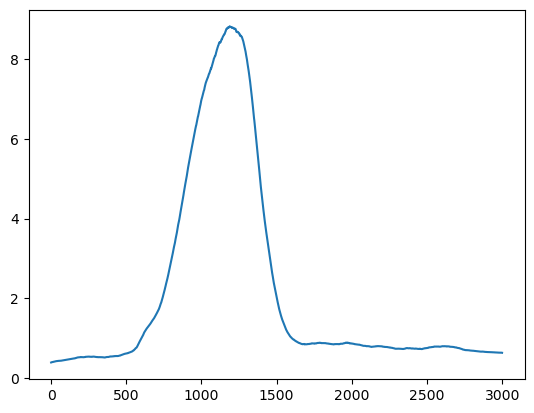

In [36]:
plt.plot(mi_fcn_time_frequency(mv, labels[None], False, True).sum(0))

In [37]:
from mne.time_frequency import psd_array_multitaper


def xr_psd_array_multitaper(data, bandwidth=1.0, n_jobs=1, fmin=0.1, fmax=80):
    _, roi, _ = data.trials.values, data.roi.values, data.times.values

    psds_c, freqs, _ = psd_array_multitaper(
        data,
        data.fsample,
        fmin=fmin,
        fmax=fmax,
        n_jobs=n_jobs,
        bandwidth=bandwidth,
        output="complex",
    )

    # Spectra
    sxx = (psds_c * np.conj(psds_c)).mean((0, 2)).real

    sxx = xr.DataArray(sxx, dims=("roi", "freqs"), coords=(roi, freqs))

    return sxx

    Using multitaper spectrum estimation with 5 DPSS windows


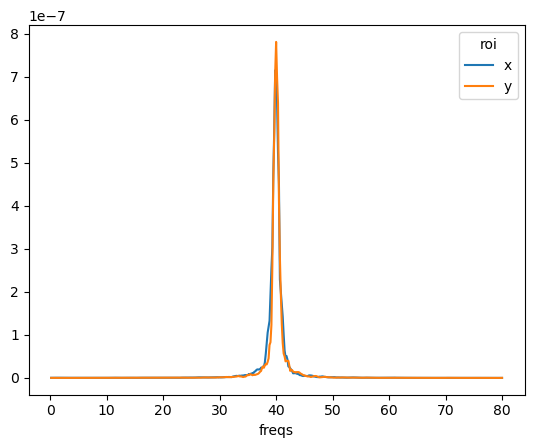

In [38]:
data.attrs["fsample"] = fsamp / decim
xr_psd_array_multitaper(data.real).plot(hue="roi")